In [7]:
import matplotlib
#from IPython.external import mathjax; mathjax.install_mathjax()
import numpy as np
import math
import sys
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
#matplotlib.style.use('ggplot')

%matplotlib inline


# Comparing the AME photometry to the dust SED fitting results:

In the 'hp_photometry' notebook, we gathered the AME and IR bands' photometry results for the 98 "AME Regions".
Now that Fred has kindly carried out the SED fitting, based on the AKARI-DIRBE-IRAS-PLANCK IR photometry, we can compare this to the AME.

## Step 1: Load-in the photometry results:

The first thing we do is just re-load our progress so far (the photometry data) into memory.

In [2]:
data_path = "../Data/"

fileout_phot = "../Data/photometry.csv"
fileout_err  = "../Data/errors.csv"
fileout_bg   = "../Data/backgrounds.csv"

healpix_AME = "../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits" ## Path to AME map
pcxv_AME = "../Data/AME.txt"

fd_all      = np.genfromtxt(fileout_phot,usecols = (0), dtype = 'float', delimiter=',',skip_header=0)
fd_err_all  = np.genfromtxt(fileout_err,usecols = (14), dtype = 'float', delimiter=',',skip_header=1)
fd_bg_all   = np.genfromtxt(fileout_bg,usecols = (0), dtype = 'float', delimiter=',',skip_header=0)

## These lines gets the AME results from Clive's paper, so we can do a comparison:
### Residual (anomalous) 28.4 GHz flux
sres_ame  = np.genfromtxt(pcxv_AME,usecols = (22), dtype = 'float', delimiter=',',skip_header=1)
sres_ame[sres_ame<=0] = np.nan
sres_ame_err = np.genfromtxt(pcxv_AME,usecols = (23), dtype = 'float', delimiter=',',skip_header=1)
sres_ame_err = sres_ame_err**2
sres_ame_err = np.sqrt(sres_ame_err)
### Peak frequency
nu_ame    = np.genfromtxt(pcxv_AME,usecols = (17), dtype = 'float', delimiter=',',skip_header=1)
### Potential fractioanl contribution from an UCHII region...
f_uch     = np.genfromtxt(pcxv_AME,usecols = (19), dtype = 'float', delimiter=',',skip_header=1)
### AME Significance
sig_ame = np.genfromtxt(pcxv_AME,usecols = (16), dtype = 'float', delimiter=',',skip_header=1)
### Dust optical depth
tau_250 = np.genfromtxt(pcxv_AME,usecols = (6), dtype = 'float', delimiter=',',skip_header=1)
## These get the coordinates of the AME regions:
#glat    = np.genfromtxt('inputlist_mep_test.list',usecols = (2), dtype = 'float', delimiter=',')
#glon    = np.genfromtxt('inputlist_mep_test.list',usecols = (1), dtype = 'float', delimiter=',')

### Potential fractioanl contribution from an UCHII region...
f_uch     = np.genfromtxt(pcxv_AME,usecols = (19), dtype = 'float', delimiter=',',skip_header=1)
### AME Significance
sig_ame = np.genfromtxt(pcxv_AME,usecols = (16), dtype = 'float', delimiter=',',skip_header=1)


## Step 2: Load-in dust SED fitting results:
Now we do the same thing for the SED fitting. Just load the columns from Fred's "results.csv" file into python variables.
(In the future, it may be better to load these as Pandas DataFrames)

In [3]:
##############Model A: Fred's Model############
###############################################
### PAH fraction

### Potential fractioanl contribution from an UCHII region...
#f_uch     = np.genfromtxt(pcxv_AME,usecols = (19), dtype = 'float', delimiter=',',skip_header=1)
### AME Significance
sig_ame = np.genfromtxt(pcxv_AME,usecols = (16), dtype = 'float', delimiter=',',skip_header=1)


### Subsets for removing points that have a NaN sres_ame value

sres_nonan = np.isnan(sres_ame)==False


### Load results intp Pandas dataframe, instead of individual variables:

[  9.80000000e+01  -1.75360363e+01   2.35464854e-01  -4.81670292e-01
   2.10324533e-01   1.40612271e-01   1.77555980e-02   1.08880285e+00]


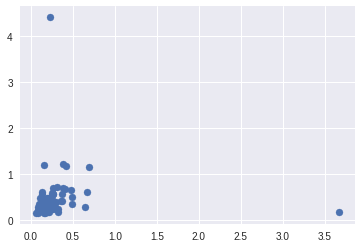

In [4]:
#sed_res_path = '/work1/users/aaronb/Databrary/fred_results_82616.csv'

sed_res_path = '../Data/fred_results_82616.csv'

sed_res_data = pd.read_csv(sed_res_path, index_col=False)

print sed_res_data.values[-1,:]
sed_res_data.head()

plt.scatter(sed_res_data['sigma(qPAH)']/sed_res_data['qPAH'], sed_res_data['sigma(ln(Md))'])

# Plots of dust vs. AME using Galliano+ (2011) model:

In [5]:
## Force background color to be white:
### Note that seaborn plotting functions my override these settings.
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['figure.facecolor']  ='white'
plt.rcParams['savefig.facecolor'] ='white'

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less_equal


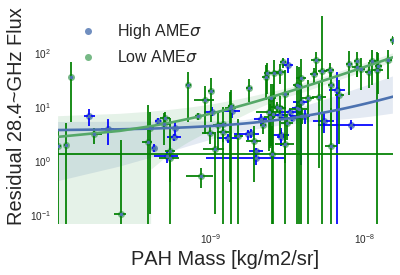

In [6]:


def pltAMEvsDust(X_, Y_, subset_hs, subset_ls, xlabel, ylabel,yerr,xerr=None,xmin=None, logy=True,logx=True, ftitle="RegPlot.pdf"):
    
    
    ## Force background color to be white:
    ### Note that seaborn plotting functions my override these settings.
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    
    fig,ax = plt.subplots()
    
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    
    if xmin is None:
        ax.set_xlim((X_.min(), X_.max()))
    else: 
        ax.set_xlim((xmin, X_.max()))
        
    
    ax = sns.regplot(x=X_[subset_hs], y= Y_[subset_hs], ci=95, fit_reg=True, robust=True, n_boot=50,  label="High AME$\sigma$")
    ax = sns.regplot(x=X_[subset_ls], y= Y_[subset_ls], ci=95, fit_reg=True, robust=True, n_boot=50,  label="Low AME$\sigma$")
    if xerr is None:
        ax.errorbar(X_[subset_hs], Y_[subset_hs], yerr=yerr[subset_hs], fmt='.',ecolor='b')
        ax.errorbar(X_[subset_ls], Y_[subset_ls], yerr=yerr[subset_ls], fmt='.',ecolor='g')
    else:
        ax.errorbar(X_[subset_hs], Y_[subset_hs], yerr=yerr[subset_hs], xerr=xerr[subset_hs],fmt='.',ecolor='b')
        ax.errorbar(X_[subset_ls], Y_[subset_ls], yerr=yerr[subset_ls], xerr=xerr[subset_ls],fmt='.',ecolor='g')
        
    if logx == True:
        ax.set_xscale('log')

    if logy == True:
        ax.set_yscale('log')

    #ax.set_ylim([0,100])
    ax.legend(fontsize=16)
    
    fig.savefig("../Plots/"+ftitle)
    
    
### Subsets separating "Highly Significant" AME from "Low/Non-significant" AME
subset_hs = (
    
    (sig_ame     > 5.000)   & 
    (f_uch       <= 0.25)    #& 

    )

subset_ls = (subset_hs == False)

Y_   = sres_ame.copy()
X_   = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) \
      * sed_res_data['qPAH'].values

yerr = sres_ame_err.copy()
xerr = np.exp(sed_res_data['sigma(ln(Md))'].values)*X_*sed_res_data['qPAH'].values

ylabel = "Residual 28.4~GHz Flux"
xlabel = "PAH Mass [kg/m2/sr]"

pltAMEvsDust(X_,
             Y_,
             subset_hs,
             subset_ls,
             xlabel,
             ylabel,
             yerr,
             xerr=xerr,
             logx=True,
             ftitle="RegsAMEvsPAHMass.pdf")

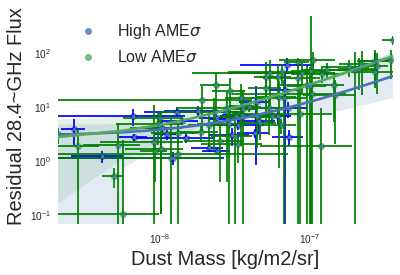

In [7]:
X_ = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values)
Y_   = sres_ame.copy()
xlabel = "Dust Mass [kg/m2/sr]"

xerr = sed_res_data['sigma(ln(Md))']*X_
yerr = sres_ame_err.copy()
pltAMEvsDust(X_, 
             Y_, 
             subset_hs, 
             subset_ls, 
             xlabel, 
             ylabel, 
             yerr,
             xerr=xerr,
             ftitle="RegsAMEvsDustMass.pdf")

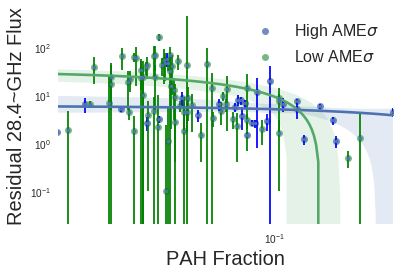

In [8]:
X_ = sed_res_data['qPAH'].values
Y_   = sres_ame.copy()
xlabel = "PAH Fraction"
xerr = sed_res_data['sigma(qPAH)'].values
yerr = sres_ame_err.copy()

pltAMEvsDust(X_, 
             Y_, 
             subset_hs, 
             subset_ls, 
             xlabel, 
             ylabel, 
             yerr,
             xmin = 0.02, 
             ftitle="RegsAMEvsqPAH.pdf")

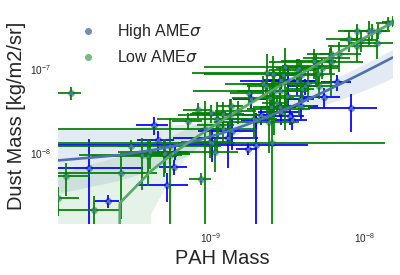

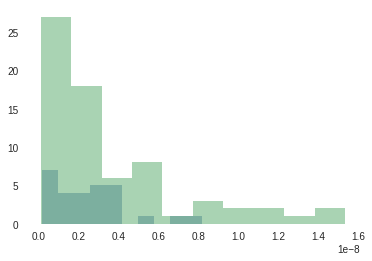

In [9]:
Y_ = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values)
ylabel = "Dust Mass [kg/m2/sr]"

X_ = sed_res_data['qPAH'].values*Y_.copy()
xlabel = "PAH Mass "

yerr = sed_res_data['sigma(ln(Md))'].values*Y_
xerr = X_*sed_res_data['sigma(ln(Md))'].values




pltAMEvsDust(
    X_, 
    Y_, 
    subset_hs, 
    subset_ls, 
    xlabel, 
    ylabel,
    yerr=yerr,
    xerr=xerr,
    logy=True, 
    logx=True,
    ftitle="RegsMDustvsMPAH.pdf")
plt.show()
plt.close()

plt.hist(X_[subset_hs],alpha=0.5)
plt.hist(X_[subset_ls],alpha=0.5)
plt.show()

plt.close()

[ 15.6  18.7   1.9   3.4   2.7   1.9   5.3   8.5   0.2   8.5   2.    3.4
   0.2   5.4   5.9   3.7   7.    1.9   7.5   nan   1.8   2.5   nan   1.3
   1.6   0.6   6.1   0.6   2.5   9.9   1.5   3.4   nan   1.8   8.5   1.5
   9.5   1.5  16.3  17.4   5.1   4.3   0.8   5.6  13.2   4.5   7.4  12.3
   4.3   7.4   8.3   7.4   2.    1.8   5.5  14.9   9.4  18.9  11.4  14.5
   9.9   4.2  14.    9.5  10.5   3.3   0.9   1.9   2.2   1.6   4.4   2.4
   2.    nan   1.9   8.9   2.    3.2   6.3   4.2   4.6   5.2   6.8   2.5
   2.4   2.9   3.4   6.    4.6   0.7   1.1   5.3   2.1  29.8   3.2  10.9
   2.9  13.3]


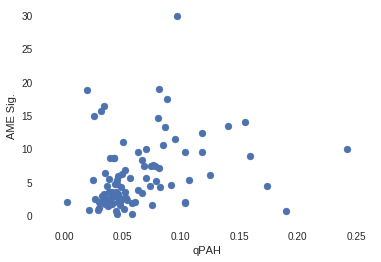

In [10]:
Y_ = sed_res_data['qPAH'].values
ylabel = "qPAH "

X_ = sig_ame
xlabel = "$\sigma_{AME}$"

yerr = sed_res_data['sigma(qPAH)'].values

print X_

plt.scatter(Y_,X_)
plt.ylabel('AME Sig.')
plt.xlabel('qPAH')
# pltAMEvsDust(
#     X_, 
#     Y_, 
#     subset_hs, 
#     subset_ls, 
#     xlabel, 
#     ylabel,
#     yerr=yerr,
#     xerr=xerr,
#     logy=False, 
#     logx=False,
#     xmin=0.1,
#     ftitle="RegsSigmaAMEvsQPAH.pdf")
# plt.show()
# plt.close()




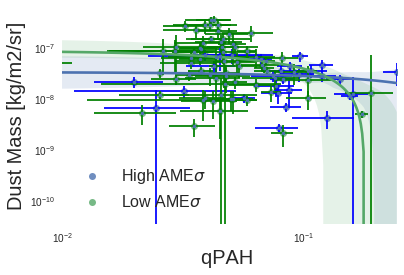

In [11]:
Y_ = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values)
ylabel = "Dust Mass [kg/m2/sr]"

X_ = sed_res_data['qPAH'].values
xlabel = "qPAH "

yerr = sed_res_data['sigma(ln(Md))'].values*Y_
xerr = sed_res_data['sigma(qPAH)'].values




pltAMEvsDust(
    X_, 
    Y_, 
    subset_hs, 
    subset_ls, 
    xlabel, 
    ylabel,
    yerr=yerr,
    xerr=xerr,
    logy=True, 
    logx=True,
    xmin=0.01,
    ftitle="RegsMDustvsQPAH.pdf")
plt.show()
plt.close()




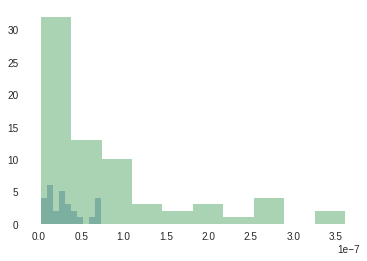

In [12]:
plt.hist(Y_[subset_hs],alpha=0.5)
plt.hist(Y_[subset_ls],alpha=0.5)
plt.show()

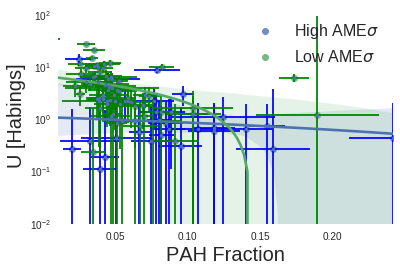

In [13]:
Y_     = np.exp(sed_res_data['ln(<U> [Habings])'].values)
ylabel = 'U [Habings]'

X_     = sed_res_data['qPAH'].values
xlabel = "PAH Fraction"
xmin = 0.01

# yerr_exp = sed_res_data['sigma(ln(<U>))'].values
# yerr_rel = yerr_exp / sed_res_data['ln(<U> [Habings])'].values
# yerr_lin = np.exp(sed_res_data['ln(<U> [Habings])'].values)*yerr_rel
yerr = np.exp(sed_res_data['sigma(ln(<U>))'].values)

pltAMEvsDust(X_, 
             Y_, 
             subset_hs, 
             subset_ls, 
             xlabel, 
             ylabel,
             yerr=yerr,
             xerr=xerr,
             xmin=xmin,
             logy=True, 
             logx=False, 
             ftitle="RegsUvsqPAH.pdf")

## Experimenting with a boostrap test:

In [14]:
import numpy.random as npr

def bootstrap(data_x, 
              data_y, 
              num_samples, 
              num_subsamples, 
              kind='Spearman'):
    
    from scipy import stats
    
    #"""Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    
    n = len(data_x)

    
    corr_coeff_array = np.ones(num_samples)
    
    if kind == 'Spearman':
    
        for i in range(0,num_samples):
            idx = npr.randint(0, n, (num_subsamples))
            samples_x = data_x[idx]
            samples_y = data_y[idx]
            stat_r, stat_p = scipy.stats.spearmanr(samples_x,samples_y, axis=0, nan_policy='omit' )
            corr_coeff_array[i] = stat_r
    
    elif kind == 'Pearson':
            
        for i in range(0,num_samples):
            idx = npr.randint(0, n, (num_subsamples))
            samples_x = data_x[idx]
            samples_y = data_y[idx]
            stat_r, stat_p = scipy.stats.pearsonr(samples_x,samples_y,axis=0)
            corr_coeff_array[i] = stat_r
    
    corr_coeff_array[np.isnan(corr_coeff_array)==False]

    return corr_coeff_array



def bootstrap_run(X1_data, 
                  X2_data, 
                  Y_data,
                  kind='Pearson', 
                  iterations=10000, 
                  title=None, 
                  X1_label=None, 
                  X2_label=None,
                  ftitle='Bootstrap' ):
    
        ## Force background color to be white:
    ### Note that seaborn plotting functions my override these settings.
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    
    
    corr_array_X1 = bootstrap(X1_data,Y_data, iterations, len(X1_data),kind=kind)

    corr_array_X2 = bootstrap(X2_data,Y_data, iterations, len(X2_data), kind=kind)
    
    X1 = corr_array_X1
    X2 = corr_array_X2
    
    X1 = X1[~np.isnan(X1)]
    X2 = X2[~np.isnan(X2)]
    
    t, prob = scipy.stats.ttest_ind(X1,X2, axis=0, equal_var=True) #Equal_var=False for Welch's t-test
    # make plots
    
    plt.figure(figsize=(6,6))

    round_it = 2

    bins = np.linspace(0.1, 1.0, 100)

    plt.hist(X1, bins, alpha=0.5, color= 'r', label=X1_label +" "+ 
                                           str(round(np.nanmean(X1),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X1),round_it)) )
    plt.hist(X2, bins, alpha=0.5, color= 'b', label=X2_label+" "+ 
                                           str(round(np.nanmean(X2),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X2),round_it))
                                            + "\n" + "t-stat: "+ 
                                                       str(round(t,1))+", p-value: "+   str(round(prob,5)))
    plt.ylabel("Count", fontsize=20)
    plt.xlabel("$S$", fontsize=20)
    
    #if X3_data:
    #    corr_array_lOri_L = bootstrap(X3_data, Y_data, iterations, len(X3_data), kind=kind )
    #    xL = corr_array_lOri_L
        
    #    pylab.hist(xL, bins, alpha=0.5, label=("Dust Luminosity vs. AME \n R = "+ str(round(np.nanmean(xL),round_it))) + " +/- " + str(round(np.nanstd(xL),round_it)))
    
    #corr_array_lOri_L = bootstrap(X3_data, Y_data, iterations, len(X3_data), kind=kind )
    #xL = corr_array_lOri_L
        
    #pylab.hist(xL, bins, alpha=0.5, label=("Dust Luminosity vs. AME \n R = "+ str(round(np.nanmean(xL),round_it))) + " +/- " + str(round(np.nanstd(xL),round_it)))
    
    
    #plt.title('Hist. of Bootstrapped '+kind+' Corr. Results')
#     import datetime
#     timestamp = datetime.datetime.now().strftime("%I:%M%p%B%d,%Y")

    
    plt.legend(loc='upper left')
    plt.savefig("../Plots/"+ftitle)
    plt.show()


    

In [15]:
print subset_ls[subset_ls==False]

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


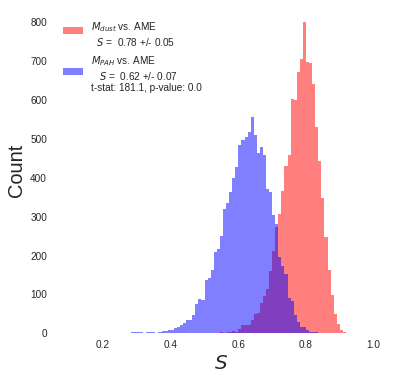

In [16]:
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values)
X2_data = X1_data*sed_res_data['qPAH'].values

# Y_data = Y_data[subset_hs==True]
# X1_data = X1_data[subset_hs==True]
# X2_data = X2_data[subset_hs==True]


    
X1_label = "$M_{dust}$ vs. AME \n  $S$ = "
X2_label = "$M_{PAH}$ vs. AME \n   $S$ = "

ftitle ="RegsAME_Bootstrap_MDustandMPAH.pdf"

iterations = 10000

kind = 'Spearman'
bootstrap_run(
    X1_data, 
    X2_data, 
    Y_data, 
    kind=kind, 
    X1_label = X1_label, 
    X2_label = X2_label, 
    iterations=iterations, 
    ftitle=ftitle)



## Calculate bootstrap results using PAH Luminosity ( not PAH Mass)

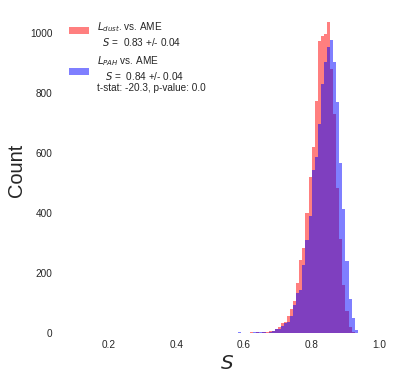

In [17]:
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(<U> [Habings])'].values)*np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = X1_data*sed_res_data['qPAH'].values 
    
X1_label = "$L_{dust}$. vs. AME \n  $S$ = "
X2_label = "$L_{PAH}$ vs. AME \n   $S$ = "

ftitle ="RegsAME_Bootstrap_LDustandLPAH.pdf"

iterations = 10000

kind = 'Spearman'
bootstrap_run(
    X1_data, 
    X2_data, 
    Y_data, 
    kind=kind, 
    X1_label = X1_label, 
    X2_label = X2_label, 
    iterations=iterations, 
    ftitle=ftitle)



# Make a Bootstrap code that incorporates the noises:

In [18]:
import numpy as np
import numpy.random as npr
from scipy import stats
import matplotlib.pyplot as plt

def noisyBootstrap(
              data_x, 
              data_y,
              noise_x,
              noise_y,
              kind='Spearman',
              niterations=1):
    
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic.
    Ye be warned, this function assumes guassian noise"""
    
    n = len(data_x)

    
    corr_coeff_array = np.zeros(niterations)
    
    # Generate a whole set of random number in one go, for the noise perturbation
    # Basically, a vectorized alternative to doing it once per iteration
    
    pert_x = npr.normal(loc=0.0, scale = 1.0, size = (n,niterations))
    pert_y = npr.normal(loc=0.0, scale = 1.0, size = (n,niterations))
    
    #print "pert_x :"+str(pert_x)
    
    # Now do the same thing for the boostrap grabbing:
    
    idx = npr.randint(0, n, size = (n,niterations))
    #print "idx :"+str(np.shape(idx))
    #idy = npr.randint(0, n, size = (n,niterations))
    
    #print "noise_x :"+str(noise_x)
    
    #print "rel_noise_x :"+str(noise_x/data_x)
    
    for i in range(0,niterations):

        noisy_x        = data_x.copy() + noise_x.copy()*pert_x[:,i].copy()
        noisy_y        = data_y.copy() + noise_y.copy()*pert_y[:,i].copy()
        samples_x      = noisy_x[idx[:,i]]
        samples_y      = noisy_y[idx[:,i]]


        if kind == 'Pearson':

            stat_r, stat_p = scipy.stats.pearsonr(samples_x,samples_y,axis=0)
            
        elif kind == 'Spearman':
            
            stat_r, stat_p = scipy.stats.spearmanr(samples_x,samples_y,axis=0, nan_policy='omit')

        corr_coeff_array[i] = stat_r
    
    corr_coeff_array[np.isnan(corr_coeff_array)==False]

    return corr_coeff_array



def noisyBootstrap_run(
                  X1_data, 
                  X2_data, 
                  Y_data,
                  X1_noise,
                  X2_noise,
                  Y_noise,
                  kind='Spearman', 
                  niterations=10000, 
                  title=None, 
                  X1_label=None, 
                  X2_label=None,
                  ftitle='Bootstrap' ):
    
        ## Force background color to be white:
    ### Note that seaborn plotting functions my override these settings.
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    
    
    corr_array_X1 = noisyBootstrap(X1_data, Y_data, X1_noise,Y_noise, kind=kind, niterations=niterations)

    corr_array_X2 = noisyBootstrap(X2_data, Y_data, X2_noise,Y_noise, kind=kind, niterations=niterations)
    
    X1 = corr_array_X1
    X2 = corr_array_X2
    
    X1 = X1[~np.isnan(X1)]
    X2 = X2[~np.isnan(X2)]
    
    t, prob = scipy.stats.ttest_ind(X1,X2, axis=0, equal_var=True) #Equal_var=False for Welch's t-test
    # make plots
    
    plt.figure(figsize=(6,6))

    round_it = 2

    bins = np.linspace(0.1, 1.0, 100)

    plt.hist(X1, bins, alpha=0.5, color= 'r', label=X1_label +" "+ 
                                           str(round(np.nanmean(X1),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X1),round_it)) )
    plt.hist(X2, bins, alpha=0.5, color= 'b', label=X2_label+" "+ 
                                           str(round(np.nanmean(X2),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X2),round_it))
                                            + "\n" + "t-stat: "+ 
                                                       str(round(t,1))+"\n p-value: "+   str(round(prob,6)))
    plt.ylabel("Count", fontsize=20)
    plt.xlabel("$S$", fontsize=20)
    
    
    plt.legend(loc='upper left')
    plt.savefig("../Plots/"+ftitle)
    plt.show()
    
    return corr_array_X1, corr_array_X2


def getProductError(x,y,sigmax,sigmay):
    
    '''Given X and Y data, and corresponding absolute errors,
    get the relative errors, and then calculate the relative
    error of the product. Then convert this finally to the
    absolute error of the product. Return this error and the
    product XY.'''
    
    rel_errorx = sigmax/x
    rel_errory = sigmay/y
    
    rel_errorxy = rel_errorx + rel_errory
    prod_xy = x*y
    
    sigmaxy = rel_errorxy * (prod_xy)
    
    return sigmaxy, prod_xy

# Noisy Bootstrap Test Run:

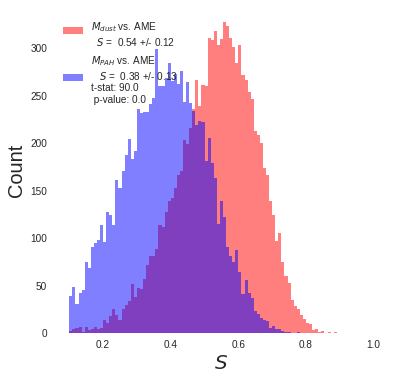

(array([ 0.36911462,  0.51421921,  0.50831525, ...,  0.62525738,
         0.55593835,  0.43397992]),
 array([ 0.44654842,  0.31556385,  0.52462918, ...,  0.10922409,
         0.1075168 ,  0.12910986]))

In [19]:
Y_data  = sres_ame
Y_noise = sres_ame_err

X1_data  = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values)
X1_rel_noise = sed_res_data['sigma(ln(Md))'].values
X1_noise = X1_rel_noise*X1_data

X2_data = X1_data*sed_res_data['qPAH']
qPAH_rel_noise = sed_res_data['sigma(qPAH)'].values/sed_res_data['qPAH'].values

X2_rel_noise = qPAH_rel_noise + X1_rel_noise
X2_noise = X2_rel_noise * X2_data

#X2_noise = (sed_res_data['sigma(qPAH)']/sed_res_data['qPAH'])+sed_res_data['sigma(ln(Md))'].values
# X2_noise, X2_data = getProductError(X1_data.copy(), sed_res_data['qPAH'].values, 
#                                     X1_noise.copy(), sed_res_data['sigma(qPAH)'].values)

#X2_noise sed_res_data['sigma(qPAH)']/sed_res_data['qPAH']

# = np.exp(sed_res_data['sigma(ln(<U>))'].values)

# Y_data = Y_data[subset_hs==True]
# X1_data = X1_data[subset_hs==True]
# X2_data = X2_data[subset_hs==True]


    
X1_label = "$M_{dust}$ vs. AME \n  $S$ = "
X2_label = "$M_{PAH}}$ vs. AME \n   $S$ = "

ftitle ="RegsAME_noisyBootstrap_MDustandMPAH_test.pdf"

niterations = 10000

noisyBootstrap_run(
    X1_data, 
    X2_data, 
    Y_data,
    X1_noise,
    X2_noise,
    Y_noise, 
    X1_label = X1_label, 
    X2_label = X2_label, 
    niterations=niterations, 
    ftitle=ftitle)



In [20]:
## Just the high sig regions: (Sample size probably too small)
### Subsets separating "Highly Significant" AME from "Low/Non-significant" AME
subset_hs = (
    
    (sig_ame     > 5.000)   & 
    (f_uch       <= 0.25)    #& 

    )

subset_ls = (subset_hs == False)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


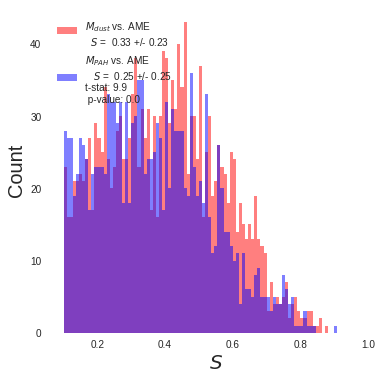

In [21]:
Y_data  = sres_ame[subset_hs]
Y_noise = sres_ame_err[subset_hs]

X1_data  = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values)[subset_hs]
X1_rel_noise = (sed_res_data['sigma(ln(Md))'].values)[subset_hs]
X1_noise = X1_rel_noise*X1_data

X2_data = X1_data*sed_res_data['qPAH'].values[subset_hs]
qPAH_rel_noise = sed_res_data['sigma(qPAH)'].values[subset_hs]/sed_res_data['qPAH'].values[subset_hs]

X2_rel_noise = qPAH_rel_noise+ X1_rel_noise
X2_noise = X2_rel_noise * X2_data

#X2_noise = (sed_res_data['sigma(qPAH)']/sed_res_data['qPAH'])+sed_res_data['sigma(ln(Md))'].values
# X2_noise, X2_data = getProductError(X1_data.copy(), sed_res_data['qPAH'].values, 
#                                     X1_noise.copy(), sed_res_data['sigma(qPAH)'].values)

#X2_noise sed_res_data['sigma(qPAH)']/sed_res_data['qPAH']

# = np.exp(sed_res_data['sigma(ln(<U>))'].values)

# Y_data = Y_data[subset_hs==True]
# X1_data = X1_data[subset_hs==True]
# X2_data = X2_data[subset_hs==True]


    
X1_label = "$M_{dust}$ vs. AME \n  $S$ = "
X2_label = "$M_{PAH}}$ vs. AME \n   $S$ = "

ftitle ="RegsAME_noisyBootstrap_MDustandMPAH_test.pdf"

niterations = 2000

Dust_S, PAH_S = noisyBootstrap_run(
    X1_data, 
    X2_data, 
    Y_data,
    X1_noise,
    X2_noise,
    Y_noise, 
    X1_label = X1_label, 
    X2_label = X2_label, 
    niterations=niterations, 
    ftitle=ftitle)



In [ ]:
Y_data = sres_ame
Y_noise = sres_ame_err

X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values)
#X2_data = X1_data*sed_res_data['qPAH'].values
X2_data = np.exp(sed_res_data['ln(<U> [Habings])'].values)

X1_noise = np.exp(sed_res_data['sigma(ln(Md))'].values)
X2_noise = np.exp(sed_res_data['sigma(ln(<U>))'].values)

# Y_data = Y_data[subset_hs==True]
# X1_data = X1_data[subset_hs==True]
# X2_data = X2_data[subset_hs==True]


    
X1_label = "$M_{dust}$ vs. AME \n  $S$ = "
X2_label = "$U_{Habings}$ vs. AME \n   $S$ = "

ftitle ="RegsAME_noisyBootstrap_MDustandU_test.pdf"

niterations = 10000

noisyBootstrap_run(
    X1_data, 
    X2_data, 
    Y_data,
    X1_noise,
    X2_noise,
    Y_noise, 
    X1_label = X1_label, 
    X2_label = X2_label, 
    niterations=niterations, 
    ftitle=ftitle)



In [ ]:
Y_data = sres_ame
X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = X1_data*sed_res_data['qPAH'].values 
X1_data = X1_data - X2_data
    
X1_label = "Dust Mass. vs. AME \n  $S$ = "
X2_label = "PAH Mass. vs. AME \n   $S$ = "

iterations = 10000


kind = 'Spearman'

ftitle ="RegsAME_Bootstrap_MDustandMPAH.pdf"

bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
              X1_label = X1_label, X2_label = X2_label, iterations=iterations, ftitle=ftitle)



In [ ]:
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = X1_data*sed_res_data['qPAH'].values 

    
X1_label = "Dust Mass. vs. AME \n  R = "
X2_label = "PAH Mass. vs. AME \n   R = "

iterations = 10000

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
              X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)




In [ ]:
#Y_data  = fd_all[~np.isnan(fd_all)]
#Y_data = sres_ame[~np.isnan(sres_ame)]
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(<U> [Habings])'].values) 
X2_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
#X3_data = phot_ori['im_lnLdust_tot_best.fits']

iterations = 10000

X1_label = "U [Habings] vs. AME \n  R = "
X2_label = "Dust Mass  vs. AME \n   R = "

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)
#kind = 'pearson'
#bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)


In [ ]:
#Y_data  = fd_all[~np.isnan(fd_all)]
#Y_data = sres_ame[~np.isnan(sres_ame)]
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(<U> [Habings])'].values)*np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
    

iterations = 1000000

X1_label = "Dust Lum. vs. AME \n   R = "
X2_label = "Dust Mass vs. AME \n   R = "

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)


In [ ]:
#Y_data  = fd_all[~np.isnan(fd_all)]
#Y_data = sres_ame[~np.isnan(sres_ame)]
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = J_dmass


#X3_data = phot_ori['im_lnLdust_tot_best.fits']

iterations = 100000

X1_label = "Dust Mass (Fred) vs. AME \n  R = "
X2_label = "Dust Mass (J13) vs. AME \n   R = "

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)


In [ ]:
Y_data  = fd_all[~np.isnan(fd_all)]
X1_data = dmass #[~np.isnan(dmass)]
X2_data = pahmass #[~np.isnan(pahmass)]
#X3_data = phot_ori['im_lnLdust_tot_best.fits']

iterations = 10000

#kind = 'pearson'

#bootstrap_run(X1_data, X2_data, Y_data, X3_data=X3_data, kind=kind, iterations=iterations, title=None)

kind = 'spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)
# kind = 'pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)


# AME to Dust comparisons, without background subtraction of the AME:

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = fd_all[:]+fd_bg_all[:]
X_ = qpah*dmass
ytitle = "AME (PR2) [Jy]"
xtitle = "PAH Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.subplot(2,2,2)
X_ = dmass
xtitle = "Dust Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.subplot(2,2,3)
Y_ = sres_ame
X_ = qpah*dmass
ytitle = "AME (PCXV) Photometry [ Jy ]"
xtitle = "PAH Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.subplot(2,2,4)
X_ = dmass
xtitle = "Dust Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = J_qpah
X_ = J_dmass
ytitle = "Dust Mass [kg/m2/sr]"
xtitle = "q_PAH"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.show()
plt.close()

### Dust Mass (THEMIS) vs. AME

In [ ]:

fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = fd_all[:]+fd_bg_all[:]
X_ = J_qpah*J_dmass
ytitle = "AME (PR2) [Jy]"
xtitle = "PAH Mass [kg/m2/sr]"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,2)
X_ = J_dmass
xtitle = "Dust Mass [kg/m2/sr]"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.show()
plt.close()

# Comparison of AME Photometry with $\tau_{250}$

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
# "Dust vs. High Sig. AME"
Y_ = fd_all[:]
X_ = tau_250[:]
ytitle = "AME (PR2) [Jy]"
xtitle = "$\\tau_{250}$ (PCXV)"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,2)
Y_ = sres_ame[:]
X_ = tau_250[:]
#"Clive's Optical Depth vs. AME"
ytitle = "AME (PCXV) [Jy]"
xtitle = "$\\tau_{250}$ (PCXV)"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)


plt.tight_layout()
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(16,16))
###############################################################
### First, plot the regions /with/ background subtraction######
###############################################################
Y_ = fd_all
X_ = sres_ame

plt.subplot(2,2,1,adjustable='box')
#plt.title("With background subtraction")
ytitle="AME (PR2) [Jy]"
xtitle="AME (PCXV) [Jy]"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)


from sklearn import svm, datasets

C = 1.0
svc = svm.SVC(kernel='linear', C=C).fit([X_[50:60], Y_[50:60]],2)


###############################################################
### Now, plot them  /without/ background subtraction###########
################################################################
#Y_ = fd_all+fd_bg_all##########################################
###############################################################
#X_ = sres_ame
#plt.subplot(2,2,2,adjustable='box')
#plt.title("Without background subtraction")
#ytitle="AME (PR2) [Jy]"
#xtitle="AME (PCXV) [Jy]"

#corr_plot(X_,Y_,  xtitle, ytitle, logscale=True)
